# Introduction
---
This project analyzes the performance of the S&P 500 index over the last five years. As a benchmark representing 500 of the largest U.S. public companies, the S&P 500 is a vital barometer of the American economy. By applying statistical calculations and data visualization, we will quantify its historical trends, volatility, and risk to build a deeper, data-driven understanding of the market's behavior.

We will use Open, High, Low, Close, and volume data to predict the next few days of closing price for the S&P 500 using Long Short-Term Memory neural network.

# Pre-processing/Feature engineering
---

## Imports

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [113]:
# data wrangling
import polars as pl
import numpy as np

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# yfinance api
import yfinance as yf

# for future classes
from dataclasses import dataclass
from typing import List, Union

# neural networks
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# sklearn for preprocessing
from sklearn.preprocessing import MinMaxScaler

## Configuration

In [114]:
with pl.Config() as cfg:
  cfg.set_tbl_cols(None)
  cfg.set_tbl_rows(500)

## Data Information

In [115]:
# download dataset
symbol = ["^GSPC"]
df = yf.download(symbol, period="5y").reset_index()
df.columns = df.columns.get_level_values(0)

/tmp/ipython-input-491198564.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="5y").reset_index()
[*********************100%***********************]  1 of 1 completed


In [116]:
sp500 = pl.from_pandas(df)

In [117]:
# (rows, columns)
sp500.shape

(1254, 6)

In [118]:
# top 5 rows
sp500.tail()

Date,Close,High,Low,Open,Volume
datetime[ns],f64,f64,f64,f64,i64
2025-08-28 00:00:00,6501.859863,6508.22998,6466.959961,6483.839844,4283760000
2025-08-29 00:00:00,6460.259766,6491.759766,6444.569824,6489.279785,4234840000
2025-09-02 00:00:00,6415.540039,6416.540039,6360.580078,6401.509766,4784000000
2025-09-03 00:00:00,6448.259766,6453.669922,6416.169922,6445.819824,4465360000
2025-09-04 00:00:00,6502.080078,6502.540039,6445.97998,6456.600098,4670770000


In [119]:
# Summary statistics
sp500.describe()

statistic,Date,Close,High,Low,Open,Volume
str,str,f64,f64,f64,f64,f64
"""count""","""1254""",1254.0,1254.0,1254.0,1254.0,1254.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0
"""mean""","""2023-03-05 19:00:17.224880""",4649.279107,4674.560248,4620.409439,4648.134706,4.3640e9
"""std""",null,800.390014,800.106683,799.102775,800.026877,9.5738e8
"""min""","""2020-09-08 00:00:00""",3236.919922,3278.699951,3209.449951,3226.139893,0.0
"""25%""","""2021-12-03 00:00:00""",4048.419922,4076.810059,4015.550049,4046.73999,3.7882e9
"""50%""","""2023-03-07 00:00:00""",4432.350098,4453.919922,4403.589844,4431.790039,4.1928e9
"""75%""","""2024-06-04 00:00:00""",5282.700195,5311.759766,5234.319824,5278.72998,4.7486e9
"""max""","""2025-09-04 00:00:00""",6502.080078,6508.22998,6466.959961,6489.279785,9.9765e9


In [120]:
# Null counts
sp500.null_count()

Date,Close,High,Low,Open,Volume
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


## Feature Engineering

In [121]:
sp500 = sp500.rename(str.lower)

In [122]:
# creating a bunch of features
sp500 = sp500.with_columns(
    sma_50 = pl.col("close").rolling_mean(50), # simple moving average that represents closing prices of a stock averaged over 50 days
    sma_200 = pl.col("close").rolling_mean(200), # simple moving average that represents closing prices of a stock averaged over 200 days
    daily_return = (pl.col("close") / pl.col("close").shift(1) - 1) * 100,
)

sp500 = sp500.with_columns(
    daily_volatility = pl.col("daily_return").std(), # the degree a price fluctuates, where high volatility indicates larger swings and lower volatility is smaller swings
)

RISK_FREE_RATE = 0.00

sp500 = sp500.with_columns(
    annualized_volatility = pl.col("daily_volatility") * (252**0.5), # since there are roughly 252 trading days in a year
    sharpe_ratio = (pl.col("daily_return").mean() - RISK_FREE_RATE) / pl.col("daily_volatility"), # measures risk-adjusted return if we had a risk free rate
    daily_return_skewness = pl.col("daily_return").skew(), # value between -1 to -0.5 or 0.5 to 1 is moderate skewness
    daily_return_kurtosis = pl.col("daily_return").kurtosis(), # statistical measure that indicates the extend to which a distribution's tails differ from a normal distribution.
    var_95 = pl.col("daily_return").quantile(0.05),
    var_99 = pl.col("daily_return").quantile(0.01),
    rolling_vol_60d = pl.col("daily_return").rolling_std(window_size=60) * (252**0.5),
    rsi_14 = pl.col('close').ewm_mean(span=14).alias('rsi_14'), # relative strength index measures the magnitude of recent price changes over a 14-period timeframe to evaluate overbought or oversold conditions in a security.
    price_diff = pl.col('close').diff()
)

In [123]:
sp500.tail()

date,close,high,low,open,volume,sma_50,sma_200,daily_return,daily_volatility,annualized_volatility,sharpe_ratio,daily_return_skewness,daily_return_kurtosis,var_95,var_99,rolling_vol_60d,rsi_14,price_diff
datetime[ns],f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-28 00:00:00,6501.859863,6508.22998,6466.959961,6483.839844,4283760000,6306.557988,5957.142344,0.315672,1.087986,17.27124,0.054488,0.116158,6.499882,-1.687729,-2.951816,9.606793,6435.401373,20.459961
2025-08-29 00:00:00,6460.259766,6491.759766,6444.569824,6489.279785,4234840000,6316.145781,5959.465942,-0.639818,1.087986,17.27124,0.054488,0.116158,6.499882,-1.687729,-2.951816,9.736795,6438.715826,-41.600098
2025-09-02 00:00:00,6415.540039,6416.540039,6360.580078,6401.509766,4784000000,6325.099785,5961.536892,-0.692228,1.087986,17.27124,0.054488,0.116158,6.499882,-1.687729,-2.951816,9.790178,6435.625721,-44.719727
2025-09-03 00:00:00,6448.259766,6453.669922,6416.169922,6445.819824,4465360000,6333.561582,5963.85824,0.510007,1.087986,17.27124,0.054488,0.116158,6.499882,-1.687729,-2.951816,9.643789,6437.31026,32.719727
2025-09-04 00:00:00,6502.080078,6502.540039,6445.97998,6456.600098,4670770000,6341.75958,5966.441741,0.834649,1.087986,17.27124,0.054488,0.116158,6.499882,-1.687729,-2.951816,9.75344,6445.946236,53.820312


In [124]:
sp500.null_count()

date,close,high,low,open,volume,sma_50,sma_200,daily_return,daily_volatility,annualized_volatility,sharpe_ratio,daily_return_skewness,daily_return_kurtosis,var_95,var_99,rolling_vol_60d,rsi_14,price_diff
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,49,199,1,0,0,0,0,0,0,0,60,0,1


In [125]:
df = sp500.drop(["sma_50", "sma_200", "rolling_vol_60d"])
df = df.drop_nulls()

## Visualization

In [126]:
!pip install mplfinance

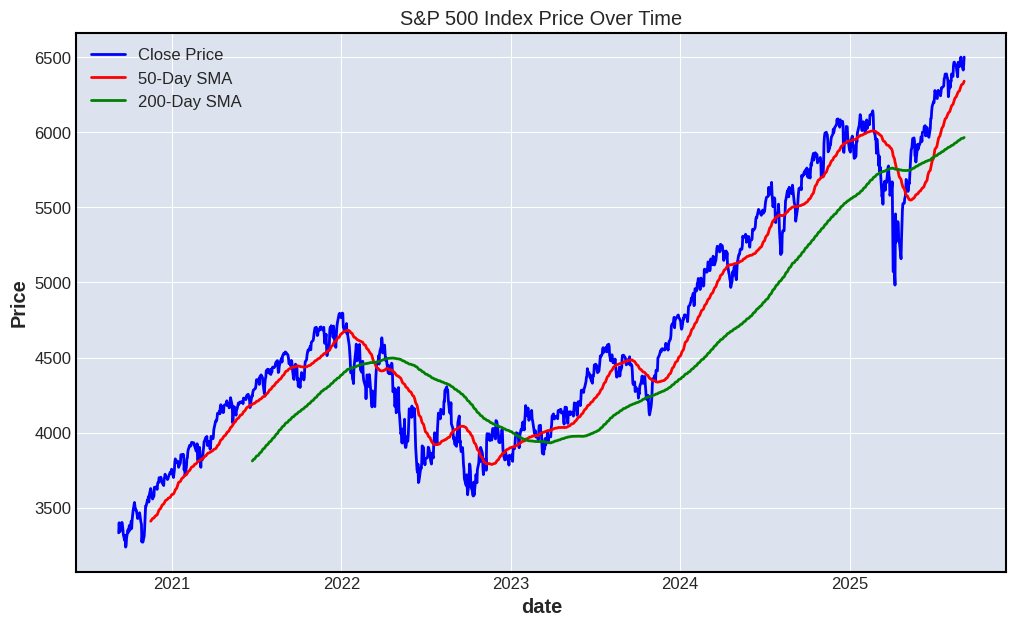

In [127]:
import mplfinance as mpf

plt.figure(figsize=(12, 7))
ax = sns.lineplot(
    data=sp500,
    x="date",
    y="close",
    label="Close Price",
    color="blue"
)

sns.lineplot(
    data=sp500,
    x="date",
    y="sma_50",
    label="50-Day SMA",
    color="red"
)

sns.lineplot(
    data=sp500,
    x="date",
    y="sma_200",
    label="200-Day SMA",
    color="green"
)

plt.title("S&P 500 Index Price Over Time")
plt.xlabel("date")
plt.ylabel("Price")
plt.show()

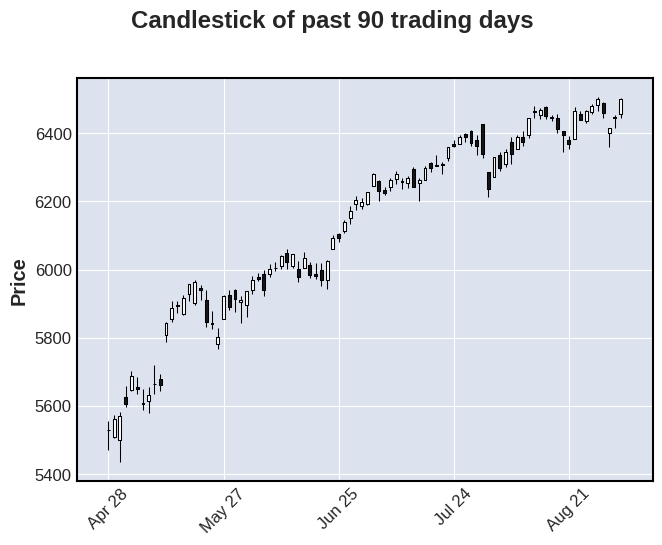

In [128]:
mpf.plot(df.to_pandas().set_index("date").iloc[-90:], type="candle", title="Candlestick of past 90 trading days")

## Preprocessing for model

In [129]:
features = ['close', 'open', 'high', 'low', 'volume', 'rsi_14']
target_feature = 'price_diff'

feature_scaler = MinMaxScaler(feature_range=(0, 1)) # scales each feature to given between 0 and 1
scaled_features = feature_scaler.fit_transform(df[features].to_numpy())

target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(df[[target_feature]].to_numpy())

In [130]:
prediction_window = 60
X, y = [], []

# use last 60 days of data to predict next day's close
for i in range(prediction_window, len(df)):
  # X contains the previous 60 days of all features
  X.append(scaled_features[i-prediction_window:i])

  # y contains the next day's closing price
  y.append(scaled_target[i, 0])

X, y = np.array(X), np.array(y)

print(X.shape, y.shape) # (samples, timesteps, features) (samples)

(1193, 60, 6) (1193,)


In [131]:
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

In [221]:
print(f"Any NaN in X_train: {torch.isnan(X_train_tensor).any()}")
print(f"Any NaN in y_train: {torch.isnan(y_train_tensor).any()}")

print(f"Any Inf in X_train: {torch.isinf(X_train_tensor).any()}")
print(f"Any Inf in y_train: {torch.isinf(y_train_tensor).any()}")

Any NaN in X_train: False
Any NaN in y_train: False
Any Inf in X_train: False
Any Inf in y_train: False


# Modeling
---

In [237]:
# @title
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, dropout_rate, output_size):
    super(LSTMModel, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # define lstm layer
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)

    # # drop out rate
    # self.droupout = nn.Dropout(dropout_rate)

    # define the fully connected output layer (aka dense layer)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    # init hidden and cell states
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    # forward propagate lstm
    out, _ = self.lstm(x, (h0, c0))

    # get output from last time step and pass it to linear layer
    out = self.fc(out[:, -1, :])
    return out

In [238]:
!pip install optuna

In [239]:
import optuna
from torch.amp import autocast, GradScaler

def objective(trial):
  hidden_size = trial.suggest_int("hidden_size", 32, 128, step=16)
  num_layers = trial.suggest_int("num_layers", 1, 2)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.4)
  learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = LSTMModel(input_size=X_train_tensor.shape[2],
                    hidden_size=hidden_size,
                    num_layers=num_layers,
                    dropout_rate=dropout_rate,
                    output_size=1).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.MSELoss()
  scaler = GradScaler()

  num_epochs = 30
  for epoch in range(num_epochs):
    model.train()
    train_inputs = X_train_tensor.to(device)
    train_targets = y_train_tensor.to(device)

    optimizer.zero_grad()
    with autocast(device_type=device.type):
      outputs = model(train_inputs)
      loss = criterion(outputs, train_targets)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

  model.eval()
  test_inputs = X_test_tensor.to(device)
  test_targets = y_test_tensor.to(device)
  with torch.no_grad():
    val_outputs = model(test_inputs)
    validation_loss = criterion(val_outputs, test_targets)

  return validation_loss.item()

In [240]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=50)

[I 2025-09-05 01:49:47,441] A new study created in memory with name: no-name-b866ec10-0366-4632-ae1a-058bc3b80f26
[I 2025-09-05 01:49:47,903] Trial 0 finished with value: 0.007139346096664667 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3103925281728012, 'learning_rate': 0.0017354742471174728}. Best is trial 0 with value: 0.007139346096664667.
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2605653376412058 and num_layers=1
  warnings.warn(
[I 2025-09-05 01:49:48,637] Trial 1 finished with value: 0.016271863132715225 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.2605653376412058, 'learning_rate': 0.0017928389612389118}. Best is trial 0 with value: 0.007139346096664667.
[I 2025-09-05 01:49:48,948] Trial 2 finished with value: 0.006986516993492842 and parameters: {'hid

In [242]:
print(f"Best validation loss: {study.best_value}")
print(f"Best hyperparams: {study.best_params}")

Best validation loss: 0.006986516993492842
Best hyperparams: {'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.2585815298053262, 'learning_rate': 0.002126051406958702}


In [253]:
best_params = study.best_params

In [254]:
# @title
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = LSTMModel(input_size=X_train.shape[2], hidden_size=best_params['hidden_size'], num_layers=best_params["num_layers"], dropout_rate=best_params["dropout_rate"], output_size=1).to(device)
final_model

LSTMModel(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.2585815298053262)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## Training

In [256]:
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])
criterion = nn.MSELoss()
scaler = GradScaler()

In [257]:
num_epochs = 50
for epoch in range(num_epochs):
    # set to training mode
    final_model.train()

    # move tensors to gpu
    train_inputs = X_train_tensor.to(device)
    train_targets = y_train_tensor.to(device)

    # zero gradients
    final_optimizer.zero_grad()

    # forward pass
    with autocast(device_type=device.type):
        outputs = final_model(train_inputs)
        loss = criterion(outputs, train_targets)

    # backward pass
    scaler.scale(loss).backward()

    # unscale and optimize
    scaler.step(final_optimizer)

    # update scaler for next step
    scaler.update()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')


Epoch [10/50], Loss: 0.003905
Epoch [20/50], Loss: 0.003642
Epoch [30/50], Loss: 0.003227
Epoch [40/50], Loss: 0.003274
Epoch [50/50], Loss: 0.003237


## Evaluation

In [258]:
# set model to evaluation mode
final_model.eval()

# disable gradient calculations
with torch.no_grad():
  test_inputs = X_test_tensor.to(device)
  predictions_tensor = final_model(test_inputs)

predictions_scaled = predictions_tensor.cpu().numpy()

In [259]:
predicted_diffs = target_scaler.inverse_transform(predictions_scaled)

test_set_start_index = len(df) - len(X_test)
previous_day_prices = df['close'][test_set_start_index-1:-1].to_numpy()

reconstructed_predictions = previous_day_prices + predicted_diffs.flatten()

real_y_test = df['close'][test_set_start_index:].to_numpy()

In [260]:
print("--- Sanity Check: First 5 Values ---")
# The actual prices on the days we are testing
print(f"Actual Prices (real_y_test):      {np.round(real_y_test[:5], 2)}")

# The prices from the DAY BEFORE that we use as a base for prediction
print(f"Previous Day Prices (for recon):  {np.round(previous_day_prices[:5], 2)}")

# Our final reconstructed predictions
print(f"Reconstructed Predictions:          {np.round(reconstructed_predictions[:5], 2)}")
print("-----------------------------------------")

--- Sanity Check: First 5 Values ---
Actual Prices (real_y_test):      [5702.55 5718.57 5732.93 5722.26 5745.37]
Previous Day Prices (for recon):  [5713.64 5702.55 5718.57 5732.93 5722.26]
Reconstructed Predictions:          [5719.14 5710.83 5726.64 5740.46 5729.1 ]
-----------------------------------------


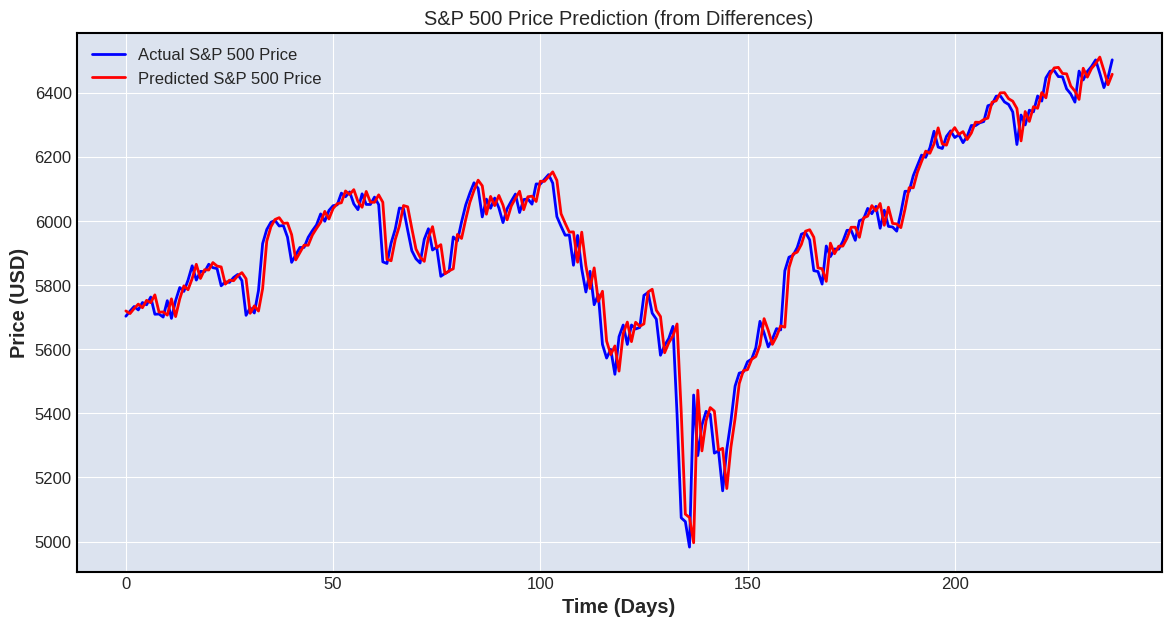

In [261]:
# plot prediction vs actual
plt.figure(figsize=(14, 7))
plt.plot(real_y_test, color='blue', label='Actual S&P 500 Price')
plt.plot(reconstructed_predictions, color='red', label='Predicted S&P 500 Price')
plt.title('S&P 500 Price Prediction (from Differences)')
plt.xlabel('Time (Days)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

* So it's correctly tracing the direction and almost has the right values.

In [262]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(real_y_test, reconstructed_predictions)
mse = mean_squared_error(real_y_test, reconstructed_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(real_y_test, reconstructed_predictions)

print("--- Model Performance Metrics ---")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"R-squared (R2) Score: {r2:.4f}")
print("-------------------------------")

--- Model Performance Metrics ---
Mean Absolute Error (MAE): $42.69
Root Mean Squared Error (RMSE): $66.63
R-squared (R2) Score: 0.9474
-------------------------------


## Predicting the next 10 days

In [270]:
df.row

close
f64
3398.959961
3339.189941
3340.969971
3383.540039
3401.199951
…
6501.859863
6460.259766
6415.540039


In [301]:
from datetime import timedelta

n_future_days = 60
n_lookback = prediction_window

close_idx = features.index('close')

# get last sequence from original dataset to start the forecast
last_sequence = scaled_features[-n_lookback:]
current_input = torch.from_numpy(last_sequence).float().unsqueeze(0).to(device)

# store the future predictions
future_predictions = []

# copy dataframe
df_forecast = df.clone()

# make sure model is still in eval mode
final_model.eval()
for _ in range(n_future_days):
  with torch.no_grad():
    # get scaled difference prediction
    predicted_scaled_diff = final_model(current_input)

    # inverse transform the difference to its dollar value
    predicted_diff = target_scaler.inverse_transform(predicted_scaled_diff.cpu().numpy())[0, 0]

    # get last known closing price
    last_known_close = df_forecast.select(pl.last("close")).item()

    # reconstruct the next day's price
    next_day_price = last_known_close + predicted_diff
    future_predictions.append(next_day_price)

    new_row_features = df_forecast.select(features).row(-1)
    new_row_features = list(new_row_features) # Convert tuple to list
    new_row_features[close_idx] = next_day_price

    # scale new record
    new_row_scaled = feature_scaler.transform(np.array(new_row_features).reshape(1, -1))

    # get last known sequence and convert to numpy
    last_sequence_numpy = current_input.cpu().numpy().squeeze(0)

    # append new scaled row and remove oldest row
    new_sequence = np.vstack([last_sequence_numpy[1:], new_row_scaled])

    # update current input for next iteration
    current_input = torch.from_numpy(new_sequence).float().unsqueeze(0).to(device)

    # update main df to include new prediction
    last_date = df_forecast.select(pl.last("date")).item()
    new_date = last_date + timedelta(days=1)

    # append to new row
    data_for_new_row = dict(zip(features, new_row_features))
    data_for_new_row['date'] = new_date
    new_row_df = pl.DataFrame(data_for_new_row, schema=df_forecast[['date'] + features].schema)

    # ensure columns from orig are present
    df_forecast = pl.concat([df_forecast[['date'] + features], new_row_df])

In [302]:
start_date = df['date'][-1] + timedelta(days=1)
end_date = start_date + timedelta(days=n_future_days - 1)

future_dates = pl.date_range(
    start=start_date,
    end=end_date,
    interval="1d",
    eager=True
).to_list()

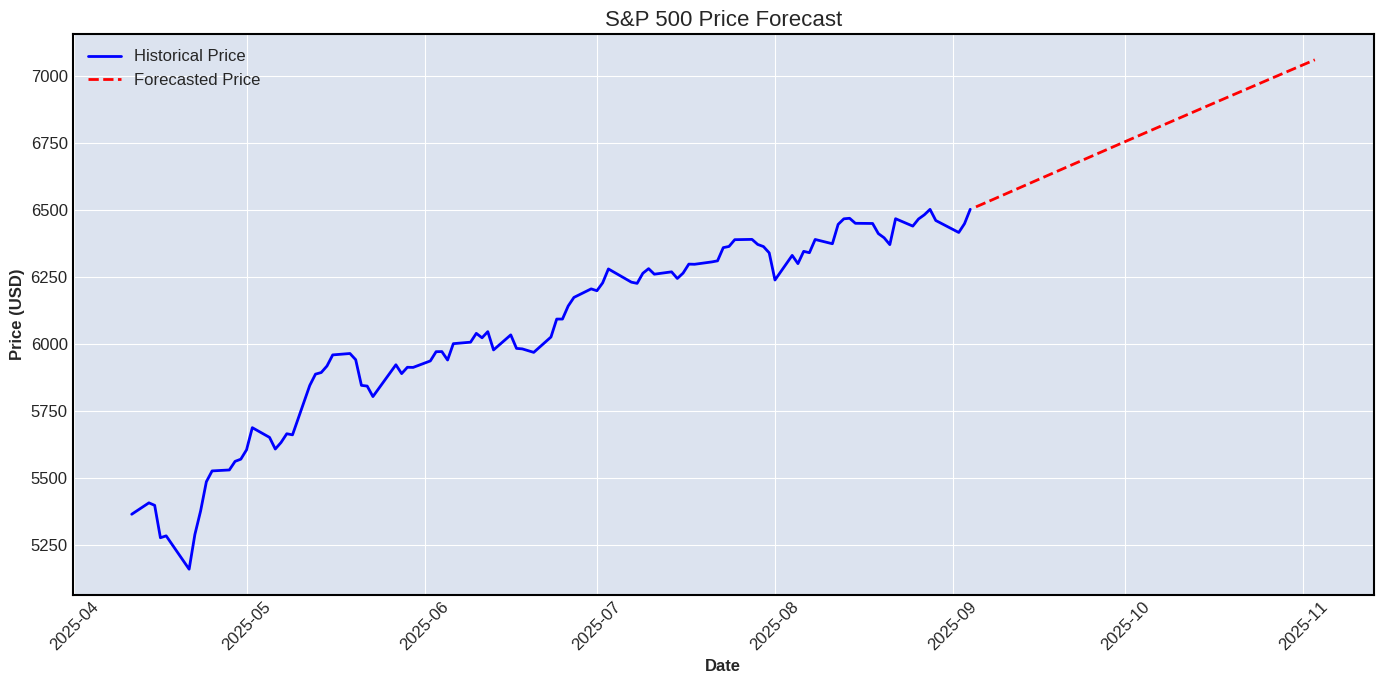

In [304]:
plt.figure(figsize=(14, 7))

plt.plot(df['date'][-100:], df['close'][-100:],
         label='Historical Price', color='blue', linewidth=2)

plt.plot(future_dates, future_predictions,
         label='Forecasted Price', color='red', linestyle='--', linewidth=2)

plt.title('S&P 500 Price Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Conclusion - How to make the model better
---
The next steps would be to incorporate real-time data because the model can only really predict the trend (red line). It can't really predict every direction the line is going to go. This red line can still be used because the S&P 500 is mostly for long-term trades and just investing your money into there like a savings account. But there are some options-trading strategies that you can make major profit on depending on the direction you believe the stock will go in. Options is actually less risky than stocks, unless you are trading naked calls and puts.

Some ideas that we can think about:
* Use new articles as a sentiment to determine the probability of what direction the stock might go up or down to. Or maybe it stays sideways, which is perfect for an Iron Condor options-trading strategy.
* Risk management system
* Feature engineer the greeks and other technical indicators into our dataframe
* Backtesting system
* Experiment with different models like GRU or Meta's Prophet, which is specifically designed for time series

Trading stocks algorithmically, you probably need real-time data. You can probably use something like NewsAPI, but it might be expensive. The free version has 100 requests a day, which is probably all you need, but news articles have a 24 hour delay. Something cool would be to measure the how news articles psychologically affect people's decision making when trading a financial instrument. I am going to research this a lot more. Hopefully, whatever solution or strategy I found out that it sets me up for life.

# Convert notebook to html
---

In [1]:
from pathlib import Path
focus_path = Path("/content/drive/MyDrive/Colab Notebooks/Trading the S&P.ipynb")

In [4]:
!jupyter nbconvert --to html "{focus_path}"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Trading the S&P.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 812245 bytes to /content/drive/MyDrive/Colab Notebooks/Trading the S&P.html
